In [20]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] = [16, 9]
from utils import *
from analysis import *
from datetime import timedelta
import pywt

In [2]:
df = pd.read_csv("Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = df.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')
Electric['Seconds'] = (Electric.Date - Electric.Date[0]).dt.total_seconds()
Electric.set_index('Date', inplace=True)

In [3]:
Electric

,Hour,Minute,Load,Seconds
Date,,,,
2008-01-01 00:15:00,0,15,15938.8,0.0
2008-01-01 00:30:00,0,30,15770.4,900.0
2008-01-01 00:45:00,0,45,15766.3,1800.0
2008-01-01 01:00:00,1,0,15415.2,2700.0
2008-01-01 01:15:00,1,15,15351.8,3600.0
...,...,...,...,...
2016-12-31 23:00:00,23,0,15952.7,284078700.0
2016-12-31 23:15:00,23,15,15865.3,284079600.0
2016-12-31 23:30:00,23,30,15693.5,284080500.0


maximum level is 13


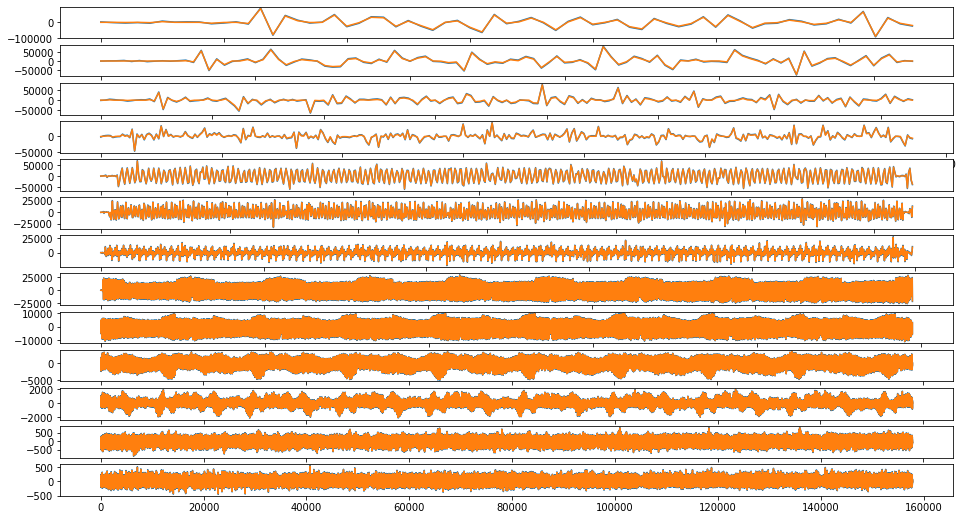

In [10]:

maxlev = pywt.dwt_max_level(len(Electric), 'coif5')
# maxlev = 6 # Override if desired
print("maximum level is " + str(maxlev))
threshold = 0.04 # Threshold for filtering

# Decompose into wavelet components, to the level selected:
coeffs = pywt.wavedec(Electric.Load.to_numpy(), 'coif5', level=maxlev)

#cA = pywt.threshold(cA, threshold*max(cA))
plt.figure()
for i in range(1, len(coeffs)):
    plt.subplot(maxlev, 1, i)
    plt.plot(coeffs[i])
    coeffs[i] = pywt.threshold(coeffs[i], mode='soft', 
                               value=threshold*max(coeffs[i]))
    plt.plot(coeffs[i])

In [5]:
datarec = pywt.waverec(coeffs, 'sym4')

In [22]:
params = latex_settings()
mpl.rcParams.update(params)

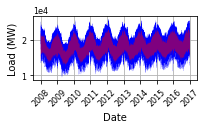

In [26]:
datarec = wavelet_filter(data=Electric.Load.to_numpy(), wavelet='coif5', threshold=0.30)

plt.plot(Electric.Load, 'b', lw=0.1, label='Raw signal')
plt.plot(Electric.index, datarec, 'r', alpha=0.5, lw=0.1,
         label='De-noised signal')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.xticks(rotation=45)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#leg = plt.legend()

#for lh in leg.legendHandles: 
 #   lh.set_alpha(1)
  #§  lh.set_linewidth(1)
plt.grid()
plt.tight_layout()
plt.savefig('./Images/Wavelet_denoise', dpi=800)

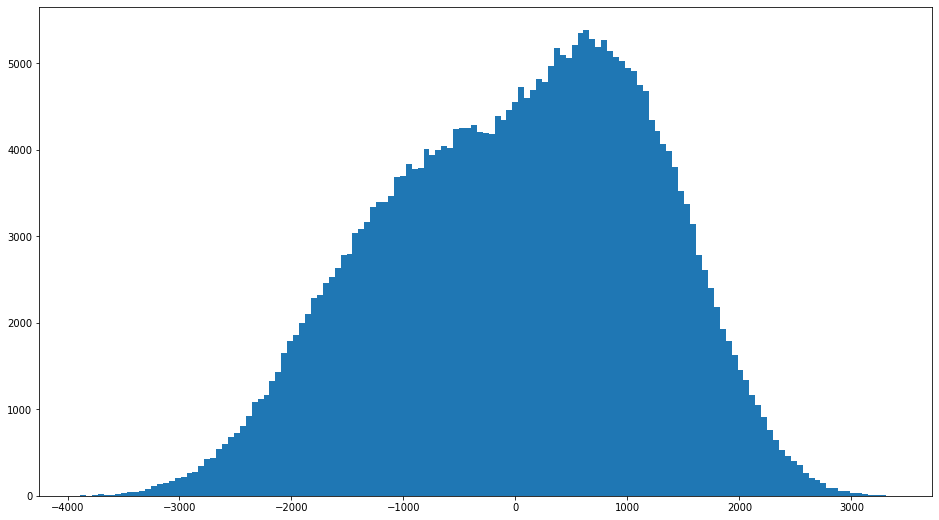

In [16]:
plt.hist(Electric.Load.to_numpy() - datarec, bins='auto');